In [26]:
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import numpy as np
import anndata
import scvi
import os
sc.set_figure_params(figsize=(4, 4))


num_of_clusters = 11

ToolName = 'scvi' 
DatasetName = 'peripheal-blood'
Data_path = '../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../results/{}/{}/'.format(DatasetName, ToolName)


if not os.path.exists(save_path):
    os.makedirs(save_path)

# for white background of figures (only for docs rendering)
# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
# %config InlineBackend.figure_format='retina'

## Loading and preparing data

In [27]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)
adata

AnnData object with n_obs × n_vars = 3666 × 18306
    var: 'gene_ids'

/var/folders/13/j6b4qnl1339416k0hpyswb8r0000gn/T/ipykernel_13607/23371428.py:7: RuntimeWarning: divide by zero encountered in log
  sorted_array = [np.log(-i) for i in variances.T][:2000]


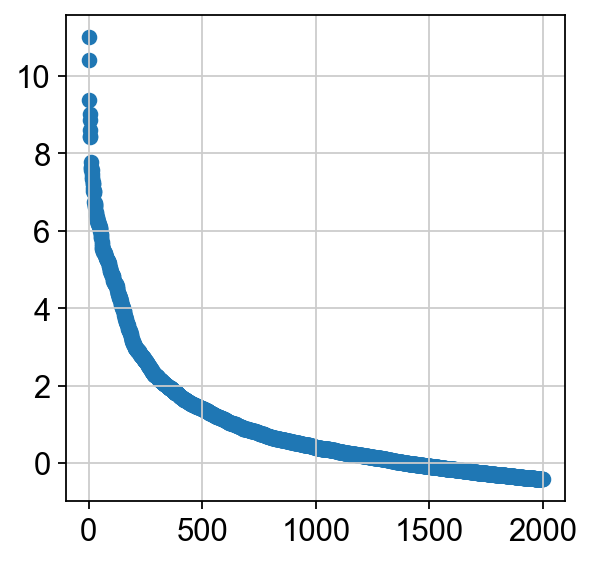

In [28]:
# adata.layers["counts"] = adata.X.copy()  # preserve counts
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
variances = np.sort(-np.var(matrix, axis=0))
sorted_array = [np.log(-i) for i in variances.T][:2000]
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)

In [29]:
adata.layers["counts"] = adata.X.copy()  # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

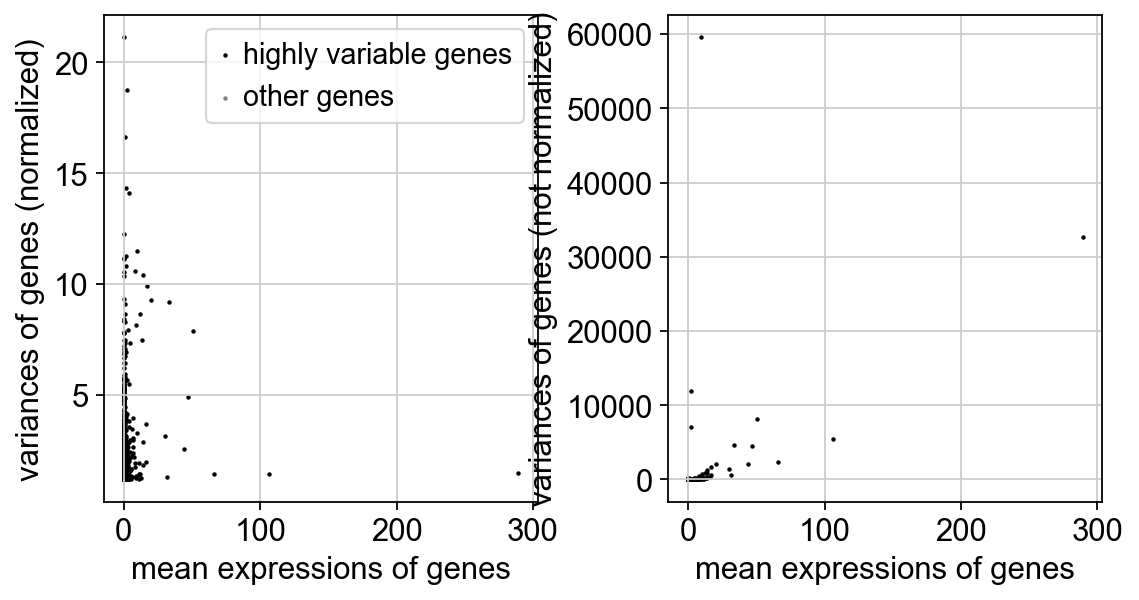

In [30]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
)
sc.pl.highly_variable_genes(adata)

In [31]:
sc.pp.scale(adata, max_value=10)

In [32]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
)

## Creating and training a model

While we highlight the scVI model here, the API is consistent across all scvi-tools models and is inspired by that of [scikit-learn](https://scikit-learn.org/stable/). For a full list of options, see the scvi [documentation](https://scvi-tools.org).

In [33]:
if os.path.exists('./models/{}/'.format(DatasetName)):
    model = scvi.model.SCVI.load('./models/{}/'.format(DatasetName), adata=adata, use_gpu=True)
else:
    model = scvi.model.SCVI(adata)
    model.train(use_gpu=False)
    model.save('./models/{}/'.format(DatasetName))
    
model

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


Epoch 400/400: 100%|██████████| 400/400 [03:13<00:00,  2.10it/s, loss=805, v_num=1] 

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [03:13<00:00,  2.07it/s, loss=805, v_num=1]


SCVI Model with the following params: 
n_hidden: 128, n_latent: 10, n_layers: 1, dropout_rate: 0.1, dispersion: gene, gene_likelihood: zinb, 
latent_distribution: normal
Training status: Trained
Model's adata is minified?: False

We can see an overview of the model by printing it.

## Obtaining model outputs

In [34]:
latent = model.get_latent_representation()

It's often useful to store the outputs of scvi-tools back into the original anndata, as it permits interoperability with Scanpy.

In [35]:
adata.obsm["X_scVI"] = latent
adata_subset = adata

In [36]:
latent_subset = model.get_latent_representation(adata_subset)

In [37]:
denoised = model.get_normalized_expression(adata_subset)
denoised.iloc[:5, :5]

,HES4,ISG15,TNFRSF18,TNFRSF4,ANKRD65
AAACCCAGTAGTTAGA,0.000079,0.000119,0.000005,0.000037,4.129708e-07
AAACGAAGTAACGATA,0.000150,0.000140,0.000016,0.000046,3.946400e-07
AAACGAAGTGGATCAG,0.000166,0.000247,0.000006,0.000003,4.804720e-06
AAACGAATCATGAGAA,0.000155,0.000506,0.000004,0.000300,7.285468e-08
AAACGCTAGGATAATC,0.000083,0.001153,0.000008,0.000353,1.118906e-06


Let's store the normalized values back in the anndata.

In [38]:
adata.layers["scvi_normalized"] = model.get_normalized_expression()

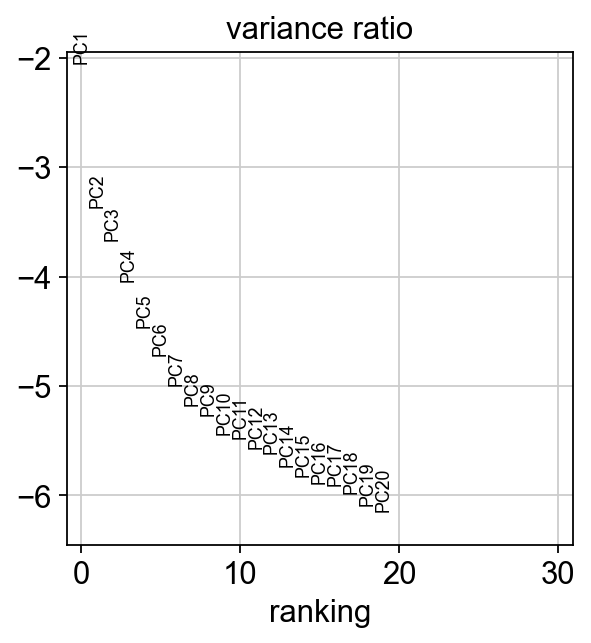

In [39]:
# run PCA then generate UMAP plots
sc.tl.pca(adata, svd_solver="arpack", n_comps=20, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

In [40]:
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=20)

In [46]:
# neighbors were already computed using scVI

res = 3.500
it = 0
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
while not (adata.obs.leiden_scVI.values.categories.values).shape == (num_of_clusters,) or res == 1:
    res += 0.01
    if it%40 == 0:
        print(res, adata.obs.leiden_scVI.values.categories.values.shape, (adata.obs.leiden_scVI.values.categories.values).shape)
    sc.tl.leiden(adata, key_added="leiden_scVI", resolution=res)
print(adata)

3.51 (39,) (39,)
3.5199999999999996 (39,) (39,)
3.5299999999999994 (39,) (39,)
3.539999999999999 (40,) (40,)
3.549999999999999 (39,) (39,)
3.5599999999999987 (40,) (40,)
AnnData object with n_obs × n_vars = 3666 × 2000
    obs: '_scvi_batch', '_scvi_labels', 'leiden_scVI'
    var: 'gene_ids', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', '_scvi_uuid', '_scvi_manager_uuid', 'pca', 'neighbors', 'leiden'
    obsm: 'X_scVI', 'X_pca'
    varm: 'PCs'
    layers: 'counts', 'scvi_normalized'
    obsp: 'distances', 'connectivities'


/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


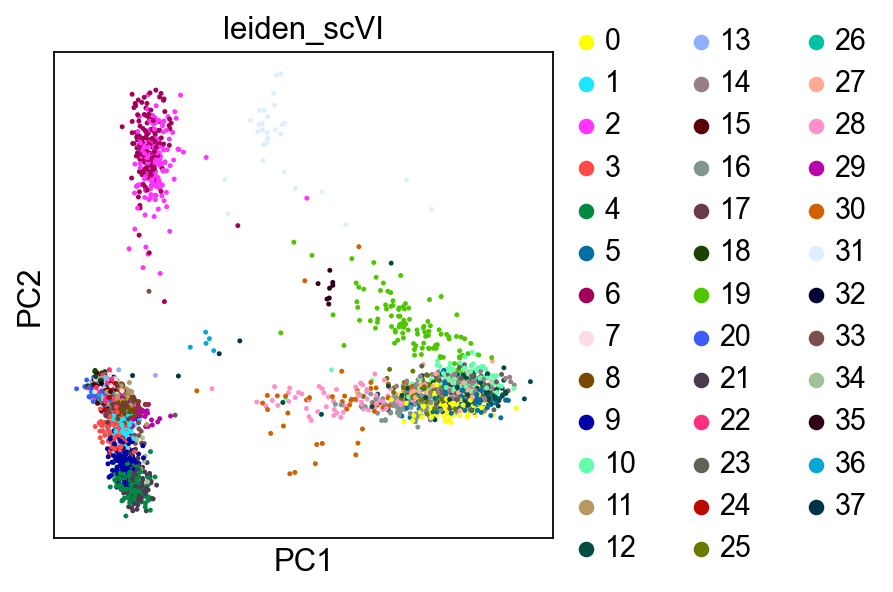

In [47]:
sc.pl.pca(
    adata,
    color=["leiden_scVI"],
    size=20,
)

In [48]:
sc.tl.rank_genes_groups(adata, 'leiden_scVI', method='wilcoxon') # method='wilcoxon' method='logreg'

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:

In [49]:
number_of_genes = 50

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(num_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] += 1
df['rank'] += 1

df.to_csv(save_path+'markers.csv', index=False)

In [50]:

df = pd.DataFrame(adata.obs['leiden_scVI'])

labels = df.rename(columns={'leiden_scVI': 'cluster'})
# rename index as cell
labels.index.names = ['cell']

labels['cluster'] = labels['cluster'].astype(int) + 1


labels.to_csv(save_path+'clustering_labels.csv')